In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Add 'hide_toggle()' in the cell to collapse

## Import Libraries

In [2]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt
hide_toggle()

## Import plot functions and define parameters

In [3]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
hide_toggle()

## Load data

In [4]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [5]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [6]:
dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
len(dat['pupil'])
pupil_area = dat['pupil'][1,:,:]
# pupil_area.shape
len(pupil_area)

340

## Group brain regions

In [8]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

## Plot: mean neural activity vs response

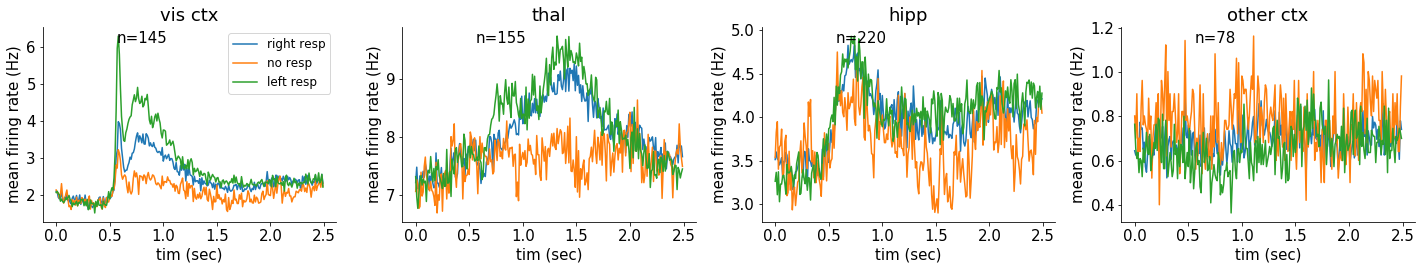

In [9]:
# plots by brain region and responses
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]
response = dat['response'] # right - nogo - left (-1, 0, 1)
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
    
    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

## Plot: mean neural activity vs task difficulty

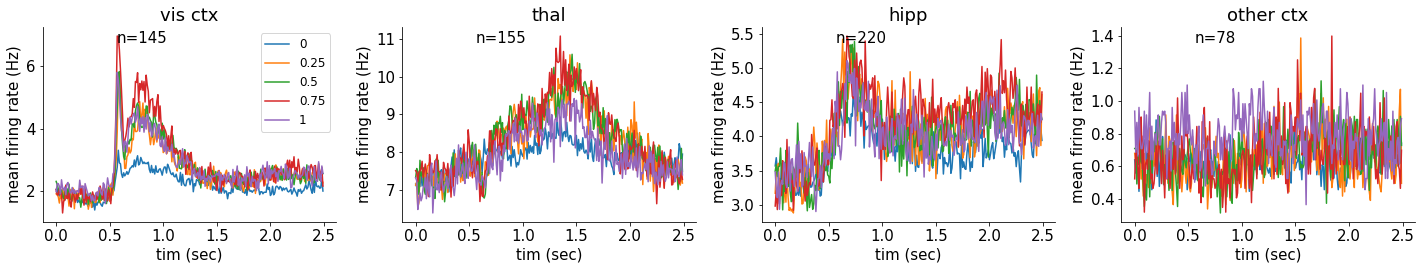

In [10]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

------------------------------------------------------------------------------------------------------------

# Encoding - Variables 

In [70]:
#note finished
#def across_all_sessions(session):
#    i = session
#    dat = alldat[i]
    #br = brain_region
    
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
brain_region_spikes = []
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

AttributeError: 'list' object has no attribute 'shape'

In [12]:
#how to iterate a for loop through multiple functions
#raw = 'asdfaa3fa'
#functions = [str.isalnum, str.isalpha, str.isdigit, str.islower,  str.isupper]  # list of functions
#
#for fn in functions:     # iterate over list of functions, where the current function in the list is referred to as fn
#    for ch in raw:       # for each character in the string raw
#        if fn(ch):        
#            print(True)
#            break

In [193]:
#function to sort through all sessions
def x_variables_across_all_sessions(session):
    i = session
    dat = alldat[i]
    #pupil data
    dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
    pupil_area = dat['pupil'][0,:,:]
    pupil_area_T = np.transpose(pupil_area)
    working_pupil_area = np.sum(pupil_area_T, axis=0)

    #choice left, nogo, right
    choice = dat['response']
    
    #reward received or not received (correct choice)
    reward = dat['feedback_type']
    
    #current trial difficulty
    l_cont = dat['contrast_left']
    r_cont = dat['contrast_right']

    arr = np.array([l_cont,r_cont])
    contrast = np.stack(arr)
    contrast_difference = contrast[0,:]-contrast[1,:]
    abs_contrast_difference = np.abs(contrast_difference)

    #trial history difficulty
    
    features = np.array([working_pupil_area, reward, working_pupil_area])
    features = np.transpose(features)

    return features

def y_variables_across_all_sessions(session, region):
    #spikes / Neuronal data
    #region 1-4
    i = session
    dat = alldat[i]
    #spikes / Neuronal data
    spikes_per_region = dat['spks'][barea==region].mean(axis=(0))
    #axis=(0,1)
    pop_spikes_per_region_T = np.transpose(spikes_per_region)
    pop_spikes_per_region = np.sum(pop_spikes_per_region_T, axis=0)    
    #pop_spikes_per_region = pop_spikes_per_region_T.sum(axis=0)
    #pop_spikes_per_region_T = np.transpose(spikes_per_region)
    #working_spikes = np.sum(pop_spikes_per_region_T[i], axis=0)
    
    return pop_spikes_per_region



#need to seperate spikes by region

In [192]:
y_variables_across_all_sessions(11,0).shape
#x_variables_across_all_sessions(11).shape

(340,)

# Encoding - Modeling Neuronal Data

In [ ]:
#current_trial_difficulty = []
#for i in contrast_difference:
#    if contrast_difference.any()==0: # difference 0
#        [0 if contrast_difference==0 else i for i in current_trial_difficulty]    
#    elif contrast_difference.any()==0.25: # difference 0.25
#        current_trial_difficulty.append(0.25)
#    elif contrast_difference.any()==0.5: # difference 0.5
#        current_trial_difficulty.append(0.5)
#    elif contrast_difference.any()==0.75: # difference 0.75
#        current_trial_difficulty.append(0.75)
#    elif contrast_difference.any()==1: # difference 1
#        current_trial_difficulty.append(1)
#    else:
#        print(current_trial_difficulty)
#    return current_trial_difficulty
#print(current_trial_difficulty)
#current_trial_difficulty

In [196]:
#https://realpython.com/linear-regression-in-python/
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

def polynomialregression(session, region):
    i = session
    r = region
    X = x_variables_across_all_sessions(i)
    y = y_variables_across_all_sessions(i, r)
    
    #Transform X
    X_ = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X)
    
    model = LinearRegression().fit(X_, y)
    
    r_sq = model.score(X_, y) #.score() returns 𝑅²
    #print('coefficient of determination:', r_sq) 
    #print('intercept:', model.intercept_)
    #print('slope:', model.coef_)
    
    #Predict the response
    #y_pred = model.predict(X)
    #print('predicted response:', y_pred, sep='\n')

    y_pred = model.predict(X_)
    print('predicted response:', y_pred, sep='\n')
    
    #Predict the response **Alternative**
    #Mean
    #y_pred = model.intercept_ + np.sum(model.coef_ * X_, axis=1)
    #print('predicted response:', y_pred, sep='\n')
    
    return print(f"coefficient of determination: {r_sq}",
                 f"intercept: {model.intercept_}",
                 f"slope: {model.coef_}"
                )

In [197]:
polynomialregression(11,1)

predicted response:
[19.93625967 18.02219717 20.76414053 19.96750967 20.53782217 20.63499014
 20.6257128  20.47825186 20.36692374 20.59934561 20.59641592 20.73874991
 20.39524405 20.74875967 19.18113272 20.77170889 20.16672842 20.56418936
 20.63206045 20.73215811 19.08079092 19.29001944 20.744121   20.61204092
 20.72922842 20.73655264 20.55735342 20.65549795 19.20408194 20.71457999
 20.76340811 19.29416983 20.69535391 20.76499502 19.24998038 19.28782217
 20.73362295 20.57004874 20.7609667  20.77244131 20.77061026 20.7519335
 20.76902334 20.69749014 20.70530264 20.77268545 20.76902334 20.76401846
 20.76780264 20.59495108 20.73801749 20.76218741 20.74265616 20.74778311
 20.76609366 20.71732657 20.77219717 20.6491503  20.74924795 19.36851065
 20.28404753 20.33644621 20.77244131 20.71482413 20.76047842 20.47043936
 20.73215811 19.24167959 20.58549063 20.69163077 20.76682608 20.71848624
 20.73069327 19.05979483 20.64283316 20.62717764 19.27170889 20.75535147
 20.52903311 20.77122061 19.3694

In [ ]:
def plot_spikes_with_prediction(spikes, predicted_spikes, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])

  plt.show()

In [ ]:
#Advanced Linear Regression With statsmodels
#x = sm.add_constant(x)

In [ ]:
#Consise Example 
# Step 1: Import packages
#import numpy as np
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures

# Step 2a: Provide data
#x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35]]
#y = [4, 5, 20, 14, 32, 22, 38, 43]
#x, y = np.array(x), np.array(y)

# Step 2b: Transform input data
#x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

# Step 3: Create a model and fit it
#model = LinearRegression().fit(x_, y)

# Step 4: Get results
#r_sq = model.score(x_, y)
#intercept, coefficients = model.intercept_, model.coef_

# Step 5: Predict
#y_pred = model.predict(x_)

# Plot: mean firing rate vs task difficulty

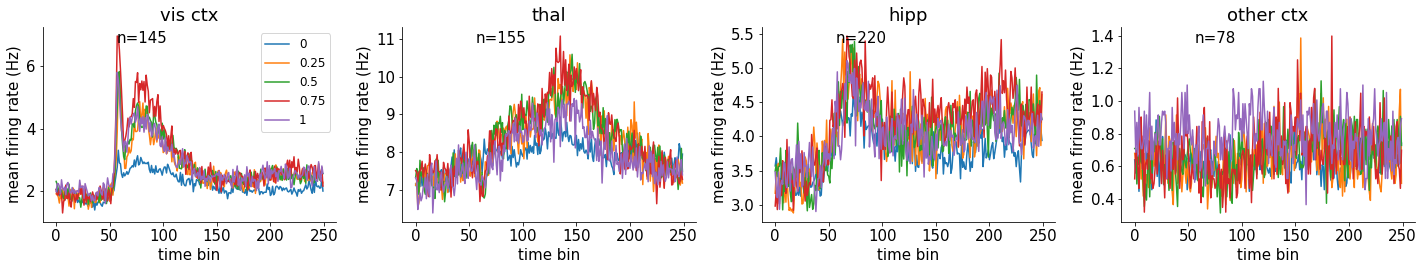

In [198]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']
    
for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,(np.abs(l_cont-r_cont))==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'time bin', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()